<H1>Relationship between IL and price change in a stableswap pool</H1>
Here we investigate the impermanent loss experienced by an LP in a stableswap pool when one of the assets depegs (its value deviates from 1USD). Because the assets in a stableswap pool are expected to remain stable, the pool is optimized to give a better execution price, with less slippage, at the expense of being more vulnerable to impermanent loss in the event of a price change. For the sake of simplicity, the LP both deposits and withdraws a proportional amount of each token (so that these trades don't induce further price changes). Note that the general dynamics and scale of the impermanent loss will hold regardless of which asset the LP chooses to deposit or withdraw.
<br><br>
An important parameter of the stableswap pool is its amplification, which affect the shape of the price curve. At an amplification of 0, the stableswap pool behaves identically to an XYK pool, whereas at an amplification of infinity, the price of each asset remains at exactly 1 until the pool runs out of liquidity. At an intermediate value, the price remains stable at a wider range of balances than it would in an XYK pool, but hits a 'cliff' when the balance shifts too far in either direction. Higher values give a more stable price but a steeper cliff, and are more appropriate when there is high confidence in the stability of the underlying assets. Here we will graph the IL dynamics for a range of amplification values.

In [1]:
import sys
import os
import glob
import random
import copy
from IPython.display import display, Markdown
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'USDA': {'usd price': 1, 'weight': 0.50},
    'USDB': {'usd price': 1, 'weight': 0.50}
}

assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 1000000

initial_state = GlobalState(
    pools={
        'stableswap': StableSwapPoolState(
            tokens={
                tkn: initial_tvl * assets[tkn]['weight'] for tkn in assets
            },
            amplification=100,
            trade_fee=0
        )
    },
    agents = {
        'LP': Agent(
            holdings={'USDA': 5000, 'USDB': 5000},
            trade_strategy=invest_all('stableswap')
        ),
        'Trader': Agent(
            holdings={tkn: 10000000000000 for tkn in assets}
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # archive_all=False
)


In [2]:
amps = [12.5, 25, 50, 100, 200]
trade_range = [2300000, 1900000, 1700000, 1500000, 1100000]
steps = 5000
amp_events = []
for i, amplification in enumerate(amps):
    initial_state.pools['stableswap'].amplification = amplification
    trade_size_min, trade_size_max = -trade_range[i], trade_range[i]
    trade_sizes = [trade_size_min + i * (trade_size_max - trade_size_min) / steps for i in range(steps)]
    events = []

    for trade_size in trade_sizes:
        # trade to change the price of assets. 
        # We assume that whatever the resulting price is the new market price, and the trade is an arb trade.
        events.append(
            run.run(initial_state, time_steps=1, silent=True)[-1].execute_swap(
                pool_id='stableswap',
                agent_id='Trader',
                tkn_sell='USDA' if trade_size > 0 else 'USDB',
                tkn_buy='USDB' if trade_size > 0 else 'USDA',
                sell_quantity=max(abs(trade_size), 0),
            )
        )

    for event in events:
        # agent withdraws assets in equal proportion
        StableSwapPoolState.execute_remove_uniform(
            state=event.pools['stableswap'],
            agent=event.agents['LP'],
            shares_removed=event.agents['LP'].holdings['stableswap']
        )

    amp_events.append(copy.deepcopy(events))
    
print('simulation finished.')

simulation finished.


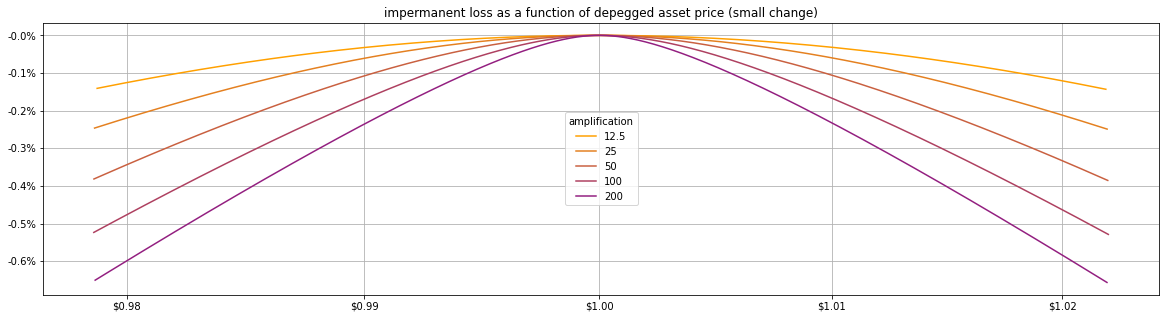

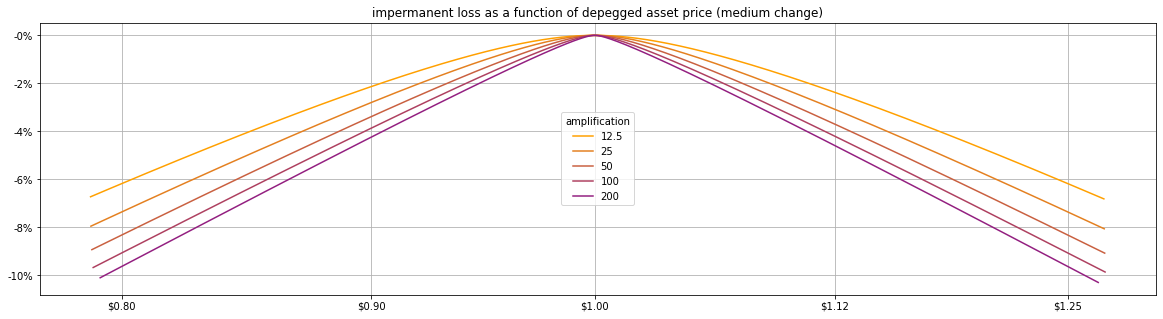

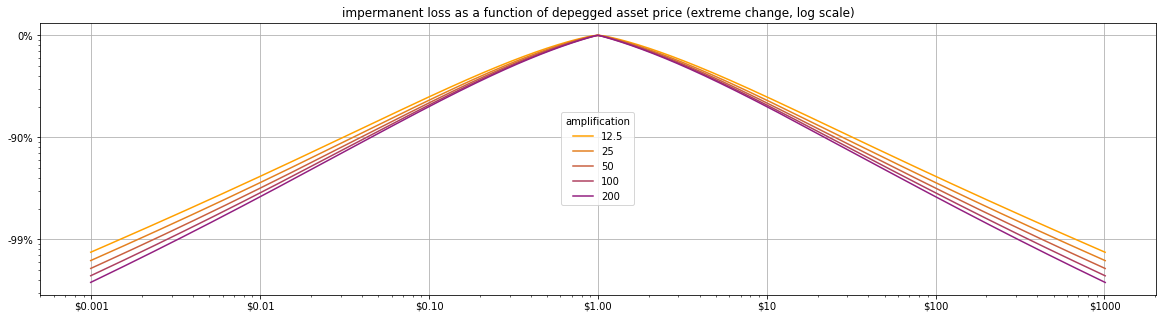

In [3]:
colors = pu.color_gradient(len(amp_events), (255, 160, 0), (120, 0, 160))
impermanent_loss = []
usda_prices = []
for i, events in enumerate(amp_events):
            
    usda_prices.append([
        1 / event.pools['stableswap'].spot_price
        for event in events
    ])
    
    asset_value = [
        value_assets(prices={'USDA': usda_prices[-1][i], 'USDB': 1}, assets=event.agents['LP'].holdings)
        for i, event in enumerate(events)
    ]

    deposit_value = [
        value_assets(prices={'USDA': usda_prices[-1][i], 'USDB': 1}, assets=initial_state.agents['LP'].holdings)
        for i, event in enumerate(events)
    ]

    impermanent_loss.append([
        asset_value[i] / deposit_value[i] - 1
        for i, event in enumerate(events)
    ])

# display(Markdown(f'<H3>Impermanent Loss Dynamics at {amps[i]} Amplification</H3>'))

# zoom in
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (small change)')
plt.xscale('log')
plt.grid()
plt.xticks(
    [0.98, 0.99, 1, 1.01, 1.02],
    ['$0.98', '$0.99', '$1.00', '$1.01', '$1.02']
)
plt.yticks(
    [-0.001 * i for i in range(7)],
    [f'-{round(0.1 * i * 10, 2) / 10}%' for i in range(7)]
)

for i, loss in enumerate(impermanent_loss):
    center = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1))[0])
    range_width = abs(center - usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1.022))[0]))
    start_range = center - range_width
    end_range = center + range_width
    plt.plot(usda_prices[i][start_range: end_range], loss[start_range: end_range], color=colors[i])
plt.legend(amps, loc='center', title='amplification')

# medium zoom
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (medium change)')
plt.xscale('log')
plt.grid()
plt.xticks(
    [0.8, 0.9, 1, 1.12, 1.25],
    ['$0.80', '$0.90', '$1.00', '$1.12', '$1.25']
)
plt.yticks(
    [-0.02 * i for i in range(6)],
    [f'-{2 * i}%' for i in range(6)]
)

for i, loss in enumerate(impermanent_loss):
    center = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1))[0])
    range_width = abs(center - usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1.27))[0]))
    start_range = center - range_width
    end_range = center + range_width
    plt.plot(usda_prices[i][start_range: end_range], loss[start_range: end_range], color=colors[i])
plt.legend(amps, loc='center', title='amplification')

# zoom out
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (extreme change, log scale)')
plt.xscale('log')
plt.grid()
plt.yscale('log')
plt.yticks(
    [1, 0.1, 0.01, 0.001],
    ['0%', '-90%', '-99%', '-99.9%']
)
tick_prices = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.xticks(
    tick_prices,
    ['$0.001', '$0.01', '$0.10', '$1.00', '$10', '$100', '$1000']
)
if 1 in tick_prices:
    tick_prices.remove(1)


for i, loss in enumerate(impermanent_loss):
    center = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1))[0])
    range_width = abs(center - usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1010))[0]))
    start_range = center - range_width
    end_range = center + range_width
    plt.plot(usda_prices[i][start_range: end_range], [1 + loss for loss in loss[start_range: end_range]], color=colors[i])
    # for price in tick_prices:
    #     best_match = usda_prices[i].index(sorted(usda_prices[i], key=lambda x: abs(x - price))[0])
    #     usda_price = usda_prices[i][best_match]
    #     l = loss[best_match]
    #     plt.annotate(
    #         text=f'{round(l * 100, 2)}%',
    #         xy=(usda_price, 1 + l),
    #         xytext=(25, 40) if i > 2 else (-50, 40),
    #         textcoords='offset points',
    #         arrowprops={'arrowstyle': '->'}
    #     )
plt.legend(amps, loc='center', title='amplification')

plt.show()